In [ ]:
## Overview 

# INPUT: data that has been preprocessed (i.e. wavelet extracted and averaged) to run partial correlation and regular spearman correlation 
# INPUT: .csv files saved in jsaal folder (now copied over to /userdata/aallawala/pain_data/stage0/redcap) 
# not structured yet to run as python script bc still working on adding other analysis. 

In [34]:
%reset
import sys
sys.path.append("/home/aallawala/")
sys.path.append("/home/aallawala/Presidio_stage1_analysis/gen_fxns")
from myimports import *
from typing import Any
from h5py._hl.base import Empty
from numpy import ndarray

In [36]:
ptID = "RCS05"
# get metadata. 
path_string = Path("/userdata/aallawala/pain_data/stage0/%s/mood_biomarker/preproc_data" % (ptID)) 

if ptID == "RCS04":
    filename = "%s_807_ieeg_wavelet.h5" % (ptID)
elif ptID == "RCS05":
    filename = "%s_1240_ieeg_wavelet.h5" % (ptID)
elif ptID == "RCS02":
    filename = "%s_246_ieeg_wavelet.h5" % (ptID)
elif ptID == "RCS07":
    filename = "%s_2267_ieeg_wavelet.h5" % (ptID)
elif ptID == "RCS06":
    filename = "%s_1713_ieeg_wavelet.h5" % (ptID)

filepath = path_string / filename
f1 = h5py.File(name=filepath)

ch_labels = f1.attrs['ch_labels']
n_ch = ch_labels.shape[0]

freqs = f1.attrs['freqs']
n_freq = len(freqs)

In [37]:
import re
tmp = re.findall(r'\d+', str(filepath))
res = list(map(int, tmp))
fileid = res[3]

In [38]:
data_root = Path(path_string)
file_keyword = '_wavelet_mean'
dataset_name = "mean_psd"

# Function to extract numeric part from filename
def extract_number(filename):
    return int(''.join(filter(str.isdigit, filename)))

def load_h5_files(path_string, file_keyword, dataset_name):
    import re
    h5_arrays = []
    fileids = [] 
    # Get list of files in directory and sort them based on numeric part
    files = sorted(os.listdir(path_string), key=extract_number)
    
    for filename in files:
        if filename.endswith('.h5') and file_keyword in filename:
            # Construct the full file path
            filepath = os.path.join(path_string, filename)
            print(filepath)
            # Load the .h5 file
            with h5py.File(filepath, 'r') as hf:
                # Assuming you want to load the first dataset from each file
                # Load the dataset as float32
                dataset = np.array(hf[dataset_name], dtype=np.float32)
                # Append the dataset to the list
                h5_arrays.append(dataset)

                # get fileids 
                tmp = re.findall(r'\d+', filepath)
                res = list(map(int, tmp))
                fileid = res[3]
                fileids.append(fileid)


    return h5_arrays, fileids

# try:
#     loaded_datasets = load_h5_files(directory_path, keyword, dataset_name)
#     # Now you can work with loaded_datasets
# except FileNotFoundError:
#     print(f"Directory '{directory_path}' not found.")

h5_arrays,fileids = load_h5_files(path_string, file_keyword, dataset_name)



/userdata/aallawala/pain_data/stage0/RCS05/mood_biomarker/preproc_data/RCS05_1074_ieeg_wavelet_mean.h5
/userdata/aallawala/pain_data/stage0/RCS05/mood_biomarker/preproc_data/RCS05_1075_ieeg_wavelet_mean.h5
/userdata/aallawala/pain_data/stage0/RCS05/mood_biomarker/preproc_data/RCS05_1076_ieeg_wavelet_mean.h5
/userdata/aallawala/pain_data/stage0/RCS05/mood_biomarker/preproc_data/RCS05_1077_ieeg_wavelet_mean.h5
/userdata/aallawala/pain_data/stage0/RCS05/mood_biomarker/preproc_data/RCS05_1078_ieeg_wavelet_mean.h5
/userdata/aallawala/pain_data/stage0/RCS05/mood_biomarker/preproc_data/RCS05_1079_ieeg_wavelet_mean.h5
/userdata/aallawala/pain_data/stage0/RCS05/mood_biomarker/preproc_data/RCS05_1080_ieeg_wavelet_mean.h5
/userdata/aallawala/pain_data/stage0/RCS05/mood_biomarker/preproc_data/RCS05_1081_ieeg_wavelet_mean.h5
/userdata/aallawala/pain_data/stage0/RCS05/mood_biomarker/preproc_data/RCS05_1082_ieeg_wavelet_mean.h5
/userdata/aallawala/pain_data/stage0/RCS05/mood_biomarker/preproc_data/RC

In [39]:
all_data  = []
all_data = np.stack(h5_arrays, axis=2)
print("freqs x channels x trials:", all_data.shape) 
del h5_arrays
del f1 
from scipy.stats import zscore
psd_z = zscore(all_data,axis = 2)

freqs x channels x trials: (40, 102, 308)


In [40]:
# for i, array in enumerate(h5_arrays):
#     shape_array = f"Array {i} shape: {array.shape}"
#     print(shape_array)

NameError: name 'h5_arrays' is not defined

In [41]:
filepath = Path ("/home/jsaal/ppt_files/%s/%s_arm1_df.csv" % (ptID, ptID)) 

# Read the CSV file into a pandas DataFrame
raw_surveys = pd.read_csv(filepath_or_buffer=filepath)
print(raw_surveys.shape)

n_trials = raw_surveys.shape[0]


(304, 407)


In [42]:
missing_bm_data = np.setdiff1d(raw_surveys.record_id, fileids) # Return the unique values in ar1 that are not in # unique vals in survey ids that dont have neural data files.

missing_surveys = np.setdiff1d( fileids, raw_surveys.record_id) # unique vals in neuraldata file ids that dont exist in survey data. 

# remove missing survey record ids from neural data. 
idx_missing_surveys = ~np.isin(fileids, missing_surveys)

new_alldata = psd_z[:,:,idx_missing_surveys]

idx_missing_neuraldata = ~np.isin(raw_surveys.record_id, missing_bm_data)
new_surveys = raw_surveys.iloc[idx_missing_neuraldata]
new_surveys.shape

assert(new_surveys.shape[0] == new_alldata.shape[2])

  

In [43]:
# Create a new list with only the elements where the boolean mask is True
filtered_list = [item for item, keep in zip(fileids, idx_missing_surveys) if keep]

print(filtered_list)


[1074, 1076, 1078, 1079, 1081, 1082, 1084, 1086, 1088, 1090, 1091, 1092, 1093, 1095, 1097, 1099, 1101, 1102, 1103, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1126, 1128, 1129, 1130, 1131, 1133, 1134, 1135, 1136, 1137, 1138, 1140, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1180, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1201, 1203, 1204, 1213, 1216, 1217, 1219, 1221, 1224, 1226, 1228, 1229, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1240, 1241, 1242, 1243, 1244, 1246, 1248, 1250, 1251, 1254, 1256, 1257, 1259, 1260, 1261, 1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1285, 1286, 1289, 1290, 1291, 1292, 1293, 1296, 1297, 1298, 1300, 1301, 1302, 1303, 1304, 1306, 130

In [44]:
remaining_diff = np.setdiff1d( new_surveys.record_id, filtered_list)
if len(remaining_diff) == 0:
    print('continue')
elif len(remaining_diff) >0:
    print('Error')

print(new_surveys.shape)
print(len(filtered_list))

continue
(253, 407)
253


In [45]:
## reshape and zscore surveys. 
# psd_z_vec = new_alldata.reshape(new_alldata.shape[2], -1)

n_feats = n_freq * n_ch 
n_trials = new_alldata.shape[2]
psd_z_vec = np.reshape(new_alldata, (n_feats, n_trials))

vasd = new_surveys['mood_vas_s0'].to_numpy()
vasp = new_surveys['intensity_vas_s0'].to_numpy()

vasd_vec = vasd.reshape(-1)
vasp_vec = vasp.reshape(-1)

def man_z_score(array):
    array_mean = np.nanmean(array)
    array_std = np.nanstd(array)
    zscore_array = (array - array_mean)/array_std
    return zscore_array

vasd_z = man_z_score(vasd_vec)
vasp_z = man_z_score(vasp_vec)

In [46]:
## remove nans from filtered data.  

def find_nans(array):
    # if nan_idx.any():
    nan_idx = np.argwhere(np.isnan(array))
    if nan_idx.any():
        print("The array contains NaN values.")
    else:
        print("The array does not contain any NaN values.") 
    return nan_idx

nan_idx_vasd = find_nans(vasd_z)
nan_idx_vasp = find_nans(vasp_z)
nan_idx_all  = np.unique([nan_idx_vasd, nan_idx_vasp])
print(nan_idx_all)
# clean up surveys from nans. 
vasd_z_clean = np.delete(vasd_z, [nan_idx_all], axis = 0)
vasp_z_clean = np.delete(vasp_z, [nan_idx_all], axis = 0)

# remove nans. 
new_surveys = new_surveys.drop(new_surveys.index[nan_idx_all], axis=0) # remove by positional index clean_psd_z= np.delete(psd_z_vec, nan_idx_all, axis=1)
clean_psd_z= np.delete(psd_z_vec, nan_idx_all, axis=1) #**** ?????
print(clean_psd_z.shape)


The array does not contain any NaN values.
The array does not contain any NaN values.
[]
(4080, 253)


In [47]:
# flip depression scores. 

# Reverse the scores
max_score = max(vasd_z_clean)
min_score = min(vasd_z_clean)

# Reverse the depression scores such that higher original scores correspond to lower new scores
vasd_z_clean_r = max_score + min_score - vasd_z_clean


In [48]:
def run_corr(x,y, n_freq, n_ch):
    from scipy.stats import spearmanr
    corr,p_value = spearmanr(x,y)
    correlations = corr[:-1,-1]
    new_corr = correlations.reshape(n_freq,n_ch)
    return new_corr

corr_vasd = run_corr(clean_psd_z.T, vasd_z_clean_r, n_freq, n_ch)
# corr_vasd = run_corr(clean_psd_z.T, vasd_z_clean, n_freq, n_ch)

corr_vasp = run_corr(clean_psd_z.T, vasp_z_clean, n_freq, n_ch)


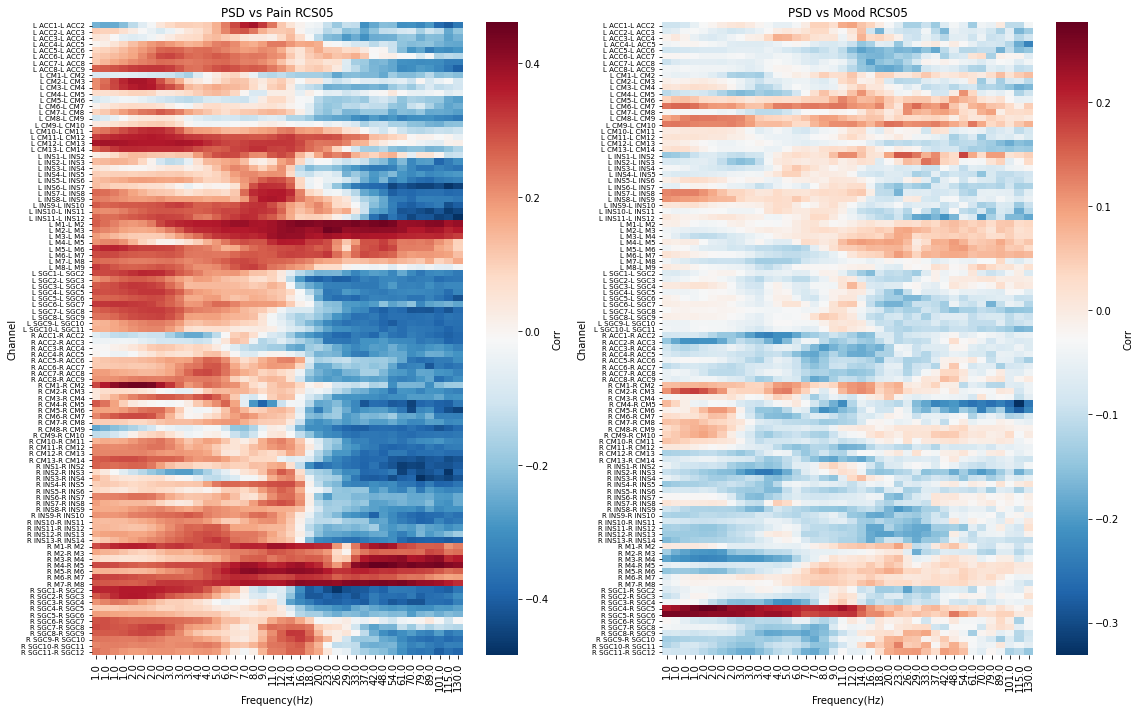

In [49]:
sys.path.append("/home/aallawala/Plotting-GenFxns/")

def basic_heatmap(ax, array, cbar_title, title):
    fig_params = [8, 12]
    caxis_lim = [-0.1, 0.2]
    
    sns.heatmap((array.T), cmap="RdBu_r", cbar=True, 
                yticklabels=ch_labels, xticklabels=np.round(freqs), 
                cbar_kws={'label': cbar_title}, ax=ax)
    ax.set_xlabel("Frequency(Hz)")
    ax.set_ylabel("Channel")
    ax.set_title(title)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=7)


def plot_heatmap_subplots(data_list, cbar_titles, titles, nrows, ncols):
    """
    Generate subplots using the custom heatmap function.

    Parameters:
    data_list (list of ndarray): List of 2D arrays to be plotted as heatmaps.
    cbar_titles (list of str): List of colorbar titles for each heatmap.
    titles (list of str): List of titles for each heatmap.
    nrows (int): Number of rows in the subplot grid.
    ncols (int): Number of columns in the subplot grid.
    """
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8 * ncols, 10 * nrows))
    axes = axes.flatten() 

    for i, (array, cbar_title, title) in enumerate(zip(data_list, cbar_titles, titles)):
        basic_heatmap(axes[i], array, cbar_title, title)

    plt.tight_layout()
    save_dir = '/userdata/aallawala/pain_data/figures/071024_mood_partialcorr/%s_corr_mood_pain.png' % (ptID)

    plt.savefig(save_dir, dpi=300, edgecolor='k', facecolor="white")
    plt.show()


# Generate some example data


# Plot the heatmaps in a 2x2 grid
plot_heatmap_subplots([corr_vasp, corr_vasd], ['Corr', 'Corr'], ['PSD vs Pain %s' % (ptID), 'PSD vs Mood %s' % (ptID)], nrows=1, ncols=2)






In [50]:
from scipy import stats, linalg

X = clean_psd_z.T
Y = vasd_z_clean_r
Z = vasp_z_clean

# Step 1: Fit regression models and obtain residuals
# Regression of Y on Z

slope_YZ, intercept_YZ, _, _, _ = stats.linregress(Z, Y)
Y_pred = slope_YZ * Z + intercept_YZ
Y_resid = Y - Y_pred

# Regression of each feature in X on Z
X_resid = np.zeros_like(X)
for i in range(n_feats):
    slope_XZ, intercept_XZ, _, _, _ = stats.linregress(Z, X[:, i])
    X_pred = slope_XZ * Z + intercept_XZ
    X_resid[:, i] = X[:, i] - X_pred

# Step 2: Compute partial correlation coefficients
partial_corr_XY_Z_reg = np.zeros(n_feats)
for i in range(n_feats):
    partial_corr_XY_Z_reg[i], _ = stats.pearsonr(X_resid[:, i], Y_resid)

print("Partial correlation coefficients between X and Y controlling for Z using regression:")
pcorr_reshaped = partial_corr_XY_Z_reg.reshape(n_freq, n_ch)

Partial correlation coefficients between X and Y controlling for Z using regression:


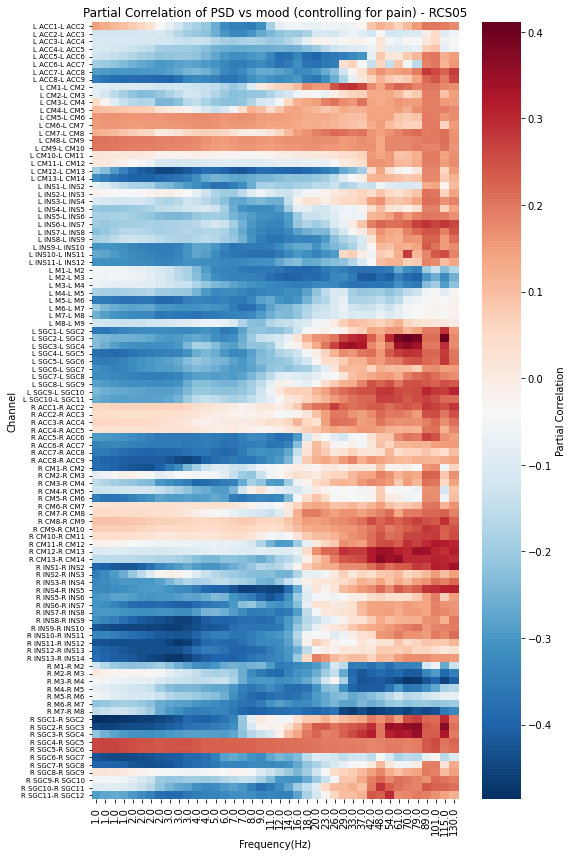

In [51]:
save_dir = '/userdata/aallawala/pain_data/figures/071024_mood_partialcorr/%s_Partial_corr_mood.png' % (ptID)
plt.figure(figsize=(8, 12))
ax = sns.heatmap((pcorr_reshaped.T), cmap="RdBu_r", cbar=True, 
    yticklabels=ch_labels, xticklabels=np.round(freqs), cbar_kws={'label': 'Partial Correlation'})
yticklabels='auto'
plt.xlabel("Frequency(Hz)")
plt.ylabel("Channel")
plt.title('Partial Correlation of PSD vs mood (controlling for pain) - %s' % (ptID))
xticklabels = 'auto'
ax.set_yticklabels(ax.get_yticklabels(), fontsize=7)

plt.tight_layout()
plt.savefig(save_dir, dpi=300, edgecolor='k', facecolor="white")

plt.show()
